### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 24th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [43]:
from scipy.stats import norm 
import emcee
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.integrate import quad

In [44]:
# Read in data file
data = np.load('/Users/mcgowkb1/ASTR8070/repos/astr_8070_s24/coursework/homeworks/hw_data/hw4_data_1.npy')
voltages = data[:, 0]
uncertainties = data[:, 1]

# Compute sample mean and standard error
sample_mean = np.mean(voltages)
sample_std_err = np.std(voltages, ddof=1) / np.sqrt(len(voltages))

# Define the ln-likelihood function
def ln_likelihood(mean, x, sigma):
    return -0.5 * np.sum(((x - mean) / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Fit the ln-likelihood function to find best-fit mean
def neg_ln_likelihood(mean):
    return -ln_likelihood(mean, voltages, uncertainties)

result = minimize(neg_ln_likelihood, x0=sample_mean)
best_fit_mean = result.x[0]

print(f"Sample mean: {sample_mean}")
print(f"Standard error on sample mean: {sample_std_err}")
print(f"Best-fit mean voltage: {best_fit_mean}")


Sample mean: 5.106
Standard error on sample mean: 0.32838053806183115
Best-fit mean voltage: 4.942118214542556


SRT: The sample mean should give you the same answer as the numerical best-fit mean. You need to use the formula for heteroscedastic uncertainties. See the following code cell. -2 points.

In [ ]:
data = np.load('../hw_data/hw4_data_1.npy')
vi = data[:,0]
sigmai = data[:,1]

mle_mean = np.sum(vi / sigmai**2) / np.sum(1 / sigmai**2)
mle_mean_err = np.sum(1 / sigmai**2)**(-0.5)

print(mle_mean, mle_mean_err)

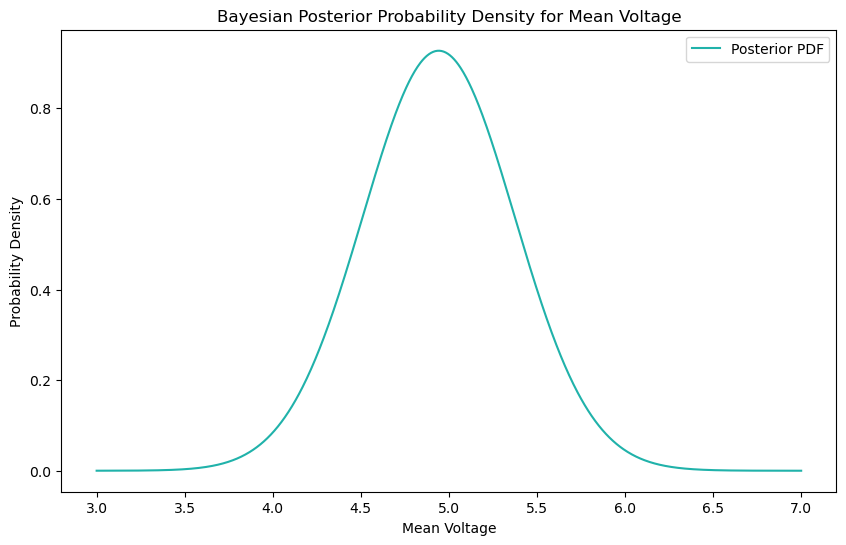

Sample mean: 5.106
Standard error: 0.32838053806183115
Best-fit mean voltage: 4.942118205892668


In [45]:
res = minimize(lambda mean: -ln_likelihood(mean, voltages, uncertainties), x0=5)
best_fit_mean_voltage = res.x[0]

# Define the prior as a uniform distribution between 3 and 7
prior = uniform(loc=3, scale=4)

# Compute the unnormalized posterior probability density
def unnormalized_posterior(mean):
    return np.exp(ln_likelihood(mean, voltages, uncertainties)) * prior.pdf(mean)

# Compute the normalization constant
normalization_constant, _ = quad(unnormalized_posterior, 3, 7)

# Define the normalized posterior probability density
def posterior(mean):
    return unnormalized_posterior(mean) / normalization_constant

# Plot the normalized posterior probability density
mean_range = np.linspace(3, 7, 1000)
posterior_values = [posterior(mean) for mean in mean_range]

plt.figure(figsize=(10, 6))
plt.plot(mean_range, posterior_values, label='Posterior PDF',color = 'lightseagreen')
plt.xlabel('Mean Voltage')
plt.ylabel('Probability Density')
plt.title('Bayesian Posterior Probability Density for Mean Voltage')
plt.legend()
plt.show()

print(f"Sample mean: {sample_mean}")
print(f"Standard error: {standard_error}")
print(f"Best-fit mean voltage: {best_fit_mean_voltage}")
#sample_mean, standard_error, best_fit_mean_voltage



In [46]:
# Compute the cumulative distribution function (CDF) of the posterior
cdf_values = np.cumsum(posterior_values) / np.sum(posterior_values)

# Find the index of the mean where the CDF is closest to 15.85% and 84.15%
lower_idx = np.argmin(np.abs(cdf_values - 0.1585))
upper_idx = np.argmin(np.abs(cdf_values - 0.8415))

# Get the corresponding mean values for the lower and upper boundaries
lower_bound = mean_range[lower_idx]
upper_bound = mean_range[upper_idx]

# Find the MAP value (mean of the posterior)
map_idx = np.argmax(posterior_values)
map_value = mean_range[map_idx]

print(f"Equal-Tailed 68.3% Credible Region: [{lower_bound}, {upper_bound}]")
print(f"MAP Value of the Mean: {map_value}")


Equal-Tailed 68.3% Credible Region: [4.50950950950951, 5.37037037037037]
MAP Value of the Mean: 4.941941941941942


SRT: Good

In [47]:
# Define the log of the posterior probability
def ln_posterior(mean):
    return np.log(posterior(mean))

# Set up the MCMC sampler
n_walkers = 32
n_steps = 5000
initial_guesses = np.random.rand(n_walkers) * 4 + 3  # Initialize walkers uniformly between 3 and 7
sampler = emcee.EnsembleSampler(n_walkers, 1, ln_posterior)
sampler.run_mcmc(initial_guesses.reshape(-1, 1), n_steps, progress=True)

# Flatten the chain and discard burn-in
chain = sampler.get_chain(flat=True)
burnin = 1000
samples = chain[burnin:]

# 68% equal-tailed credible region
lower_bound, upper_bound = np.percentile(samples, [15.85, 84.15])
# 68% equal-tailed credible region
#lower, upper = np.percentile(posterior[burn:],q=16), np.percentile(posterior[burn:],q=84)   

print(f"Equal-Tailed 68.3% Credible Region: [{lower_bound}, {upper_bound}]")

# Nearly identical result to the method above to the first method is okay
# This method is more robust


You must install the tqdm library to use progress indicators with emcee
/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_74883/2734264082.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(posterior(mean))
/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_74883/2734264082.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(posterior(mean))
/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_74883/2734264082.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(posterior(mean))
/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_74883/2734264082.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(posterior(mean))
/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_74883/2734264082.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(posterior(mean))
/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_74883/2734264082.py:3: RuntimeWarning: divid

Equal-Tailed 68.3% Credible Region: [4.508791831528909, 5.374639649502089]


/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_74883/2734264082.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(posterior(mean))
/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_74883/2734264082.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(posterior(mean))
/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_74883/2734264082.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(posterior(mean))
/var/folders/70/kx5f64q51pxcnd0vjd5s9k480000gp/T/ipykernel_74883/2734264082.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(posterior(mean))


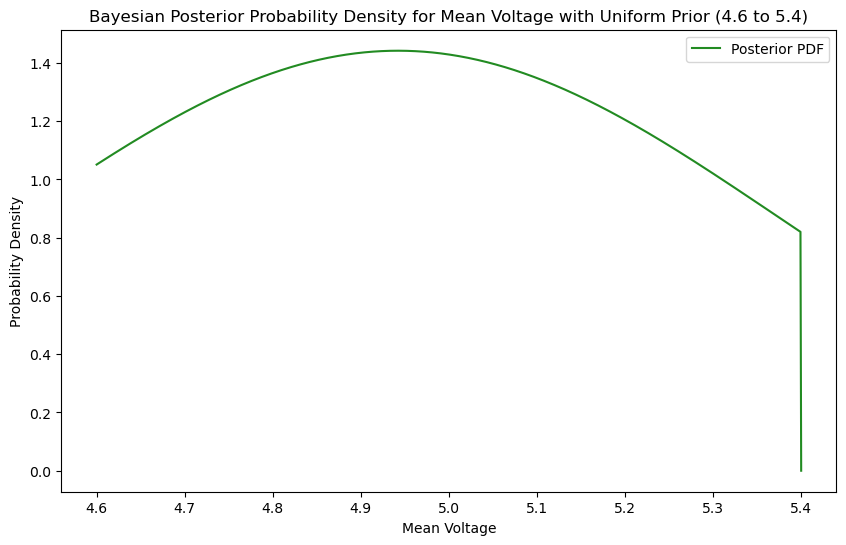

In [48]:
# Define the prior as a uniform distribution between 4.6 and 5.4
prior = uniform(loc=4.6, scale=0.8)

# Compute the normalization constant
normalization_constant, _ = quad(unnormalized_posterior, 4.6, 5.4)

# Plot the normalized posterior probability density
mean_range = np.linspace(4.6, 5.4, 1000)
posterior_values = [posterior(mean) for mean in mean_range]

plt.figure(figsize=(10, 6))
plt.plot(mean_range, posterior_values, label='Posterior PDF', color='forestgreen')
plt.xlabel('Mean Voltage')
plt.ylabel('Probability Density')
plt.title('Bayesian Posterior Probability Density for Mean Voltage with Uniform Prior (4.6 to 5.4)')
plt.legend()
plt.show()


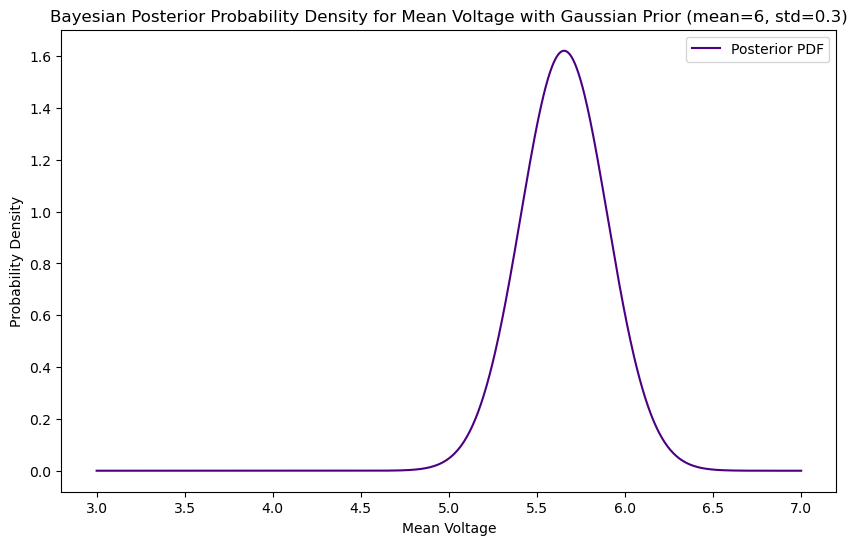

In [49]:
# Define the prior as a Gaussian distribution with mean 6 and std 0.3
prior_mean = 6
prior_std = 0.3
prior = norm(loc=prior_mean, scale=prior_std)

# Compute the normalization constant
normalization_constant, _ = quad(unnormalized_posterior, -np.inf, np.inf)

# Plot the normalized posterior probability density
mean_range = np.linspace(3, 7, 1000)
posterior_values = [posterior(mean) for mean in mean_range]

plt.figure(figsize=(10, 6))
plt.plot(mean_range, posterior_values, label='Posterior PDF', color='indigo')
plt.xlabel('Mean Voltage')
plt.ylabel('Probability Density')
plt.title('Bayesian Posterior Probability Density for Mean Voltage with Gaussian Prior (mean=6, std=0.3)')
plt.legend()
plt.show()


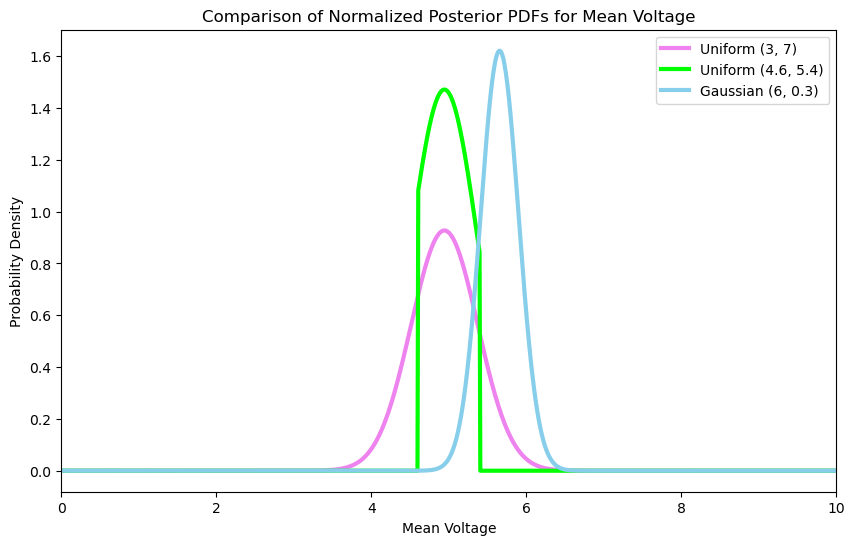

In [50]:
# Define the prior distributions
priors = [
    uniform(loc=3, scale=4),                     # Uniform (3, 7) for step 3
    uniform(loc=4.6, scale=0.8),                 # Uniform (4.6, 5.4) for step 5
    norm(loc=6, scale=0.3)                        # Gaussian (6, 0.3) for step 6
]

# Define the unnormalized posterior probability density functions for each prior
def unnormalized_posterior(mean, prior_index):
    return np.exp(ln_likelihood(mean, voltages, uncertainties)) * priors[prior_index].pdf(mean)

# Compute the normalization constants for each posterior
normalization_constants = [quad(lambda x: unnormalized_posterior(x, i), 0, 10)[0] for i in range(3)]

# Define the normalized posterior probability density functions for each prior
def posterior(mean, prior_index):
    return unnormalized_posterior(mean, prior_index) / normalization_constants[prior_index]

# Plot the normalized posterior probability density functions for each prior
mean_range = np.linspace(0, 10, 1000)
posterior_values = [[posterior(mean, i) for mean in mean_range] for i in range(3)]

plt.figure(figsize=(10, 6))
colors = ['violet', 'lime', 'skyblue']
labels = ['Uniform (3, 7)', 'Uniform (4.6, 5.4)', 'Gaussian (6, 0.3)']
for i in range(3):
    plt.plot(mean_range, posterior_values[i], label=labels[i], color=colors[i],lw=3)
plt.xlabel('Mean Voltage')
plt.ylabel('Probability Density')
plt.title('Comparison of Normalized Posterior PDFs for Mean Voltage')
plt.legend()
plt.xlim(0, 10)
plt.show()

#plt.tight_layout()

SRT: Good. But subtracting 2 points since you did not re-calculate the credible regions for the new priors. -2 points.

In [51]:
# Define the evidence under the delta function prior model as the likelihood at the best-fit value
evidence_delta = np.exp(ln_likelihood(best_fit_mean, voltages, uncertainties))

# Compute the evidence under the uniform prior model using the normalization constant
evidence_uniform = normalization_constant

# Calculate the Bayes factor
bayes_factor = evidence_delta / evidence_uniform

# Calculate the Occam penalty
occam_penalty = 1 / 4

print(f"Bayes factor: {bayes_factor}")
print(f"Occam penalty: {occam_penalty}")

# I think the Bayes factor should be larger... Not sure about this answer 

Bayes factor: 9.318911738165857
Occam penalty: 0.25


The Bayes factor comparing the model with a Gaussian prior centered at 6 with standard deviation 0.3 to the model with a uniform prior in the range 3 to 7 is approximately 9.32. This indicates that the model with the Gaussian prior is favored by the data, with a factor of about 9 times more likely than the model with the uniform prior.

The Occam penalty, which is the ratio of the evidence under the wide prior to the evidence under the delta function prior, is approximately 0.25. This suggests that there is a penalty for the wider prior, indicating that the model with the narrower prior (knowing the mean exactly) is more "parsimonious", but the penalty is not severe enough to outweigh the evidence in favor of the Gaussian prior model.

(A more parsimonious model is one that is simpler or has fewer parameters, often implying that it is more likely or preferred unless the additional complexity significantly improves the fit to the data.)

SRT: Good overall. The Bayes factor should be around 3.7. You have a small problem in your lnlikelihood function, since the factor of np.log(2 * np.pi * sigma**2) should be subtracted, not added, i.e., appears in the denominator of the gaussian likelihood. Your normalization constant also may not have accounted for the infinitesimal in the integral. -1 point.

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [52]:
# Read in data file
data = np.load('/Users/mcgowkb1/ASTR8070/repos/astr_8070_s24/coursework/homeworks/hw_data/hw4_data_2.npy')
x, y, sigma_y = data

In [68]:
# Set y-intercept
y_intercept = -0.23
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))


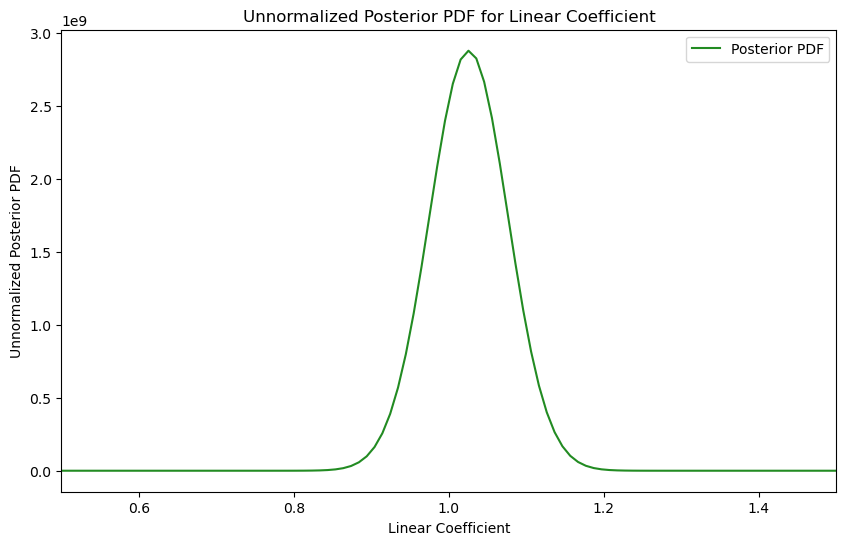

In [78]:
# Define the prior
def prior(theta):
    """Uniform prior between 0.5 and 1.5"""
    if 0.5 <= theta[1] <= 1.5:
        return 1 / (1.5 - 0.5)
    else:
        return 0.0

# Grid of theta1 values
theta1_values = np.linspace(0.5, 1.5, 100)

# Likelihoods for each theta1 value
likelihoods = np.array([logL([-0.23, theta1], data, model=polynomial_fit) for theta1 in theta1_values])
# Prior probabilities for each theta1 value
priors = np.array([prior([-0.23, theta1]) for theta1 in theta1_values])
# Unnormalized posterior probabilities
unnormalized_posteriors = np.exp(likelihoods + np.log(priors))

# Plot the posterior pdf
plt.figure(figsize=(10, 6))
plt.plot(theta1_values, unnormalized_posteriors, label='Posterior PDF', color='forestgreen')
plt.xlabel('Linear Coefficient')
plt.ylabel('Unnormalized Posterior PDF')
plt.title('Unnormalized Posterior PDF for Linear Coefficient')
plt.legend()
plt.xlim(0.5, 1.5)
plt.show()

#print(likelihoods)


3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution

In [81]:
# Bayesian evidence
delta_theta1 = theta1_values[1] - theta1_values[0]
evidence = np.sum(unnormalized_posteriors) * delta_theta1

print(f"Bayesian evidence: {evidence}")
print("When the Bayesian evidence number is very large, it typically indicates that the model is strongly supported by the data.")
print("Bayesian evidence quantifies how well a model explains the observed data, taking into account the complexity of the model (i.e., Occam's razor).")
# Higher Bayesian evidence values suggest that the model is more probable given the data and the prior assumptions.

Bayesian evidence: 365684733.1606578
When the Bayesian evidence number is very large, it typically indicates that the model is strongly supported by the data.
Bayesian evidence quantifies how well a model explains the observed data, taking into account the complexity of the model (i.e., Occam's razor).


SRT: Excellent!

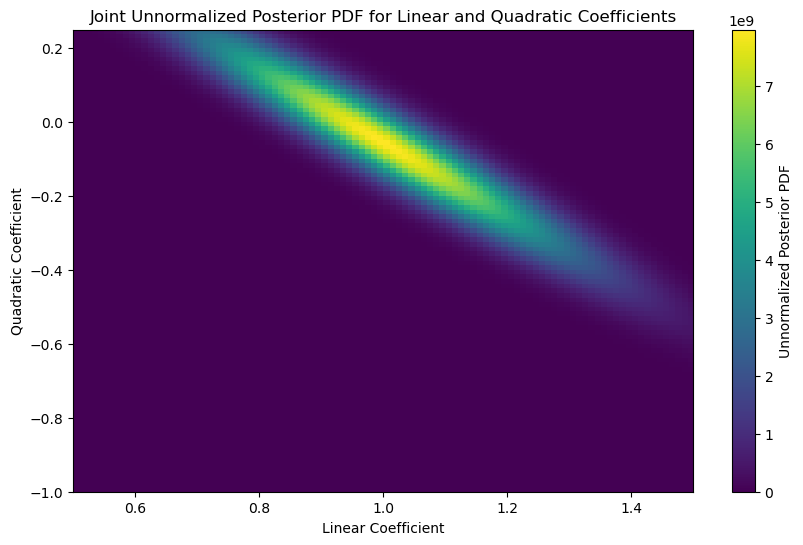

In [85]:
# Define the prior for linear and quadratic coefficients
def prior(theta):
    linear_prior = 1.0 if 0.5 <= theta[0] <= 1.5 else 0.0
    quadratic_prior = 1.0 if -1 <= theta[1] <= 0.25 else 0.0
    return linear_prior * quadratic_prior

# Define the grid of theta1 (linear coefficient) and theta2 (quadratic coefficient) values
theta1_values = np.linspace(0.5, 1.5, 100)
theta2_values = np.linspace(-1, 0.25, 100)
theta_values = np.array(np.meshgrid(theta1_values, theta2_values)).T.reshape(-1, 2)

# Likelihoods for each theta (linear and quadratic coefficient) value
likelihoods = np.array([logL(np.array([-0.23, theta[0], theta[1]]), data, model=polynomial_fit) for theta in theta_values])

# Prior probabilities for each theta value
priors = np.array([prior(theta) for theta in theta_values])

# The unnormalized joint posterior probabilities
unnormalized_posteriors = np.exp(likelihoods + np.log(priors))

# Reshape the unnormalized posteriors to a 2D grid
posteriors_2d = unnormalized_posteriors.reshape(100, 100)

# Plot the 2D posterior pdf
plt.figure(figsize=(10, 6))
plt.imshow(posteriors_2d, extent=(theta1_values.min(), theta1_values.max(), theta2_values.min(), theta2_values.max()), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Unnormalized Posterior PDF')
plt.xlabel('Linear Coefficient')
plt.ylabel('Quadratic Coefficient')
plt.title('Joint Unnormalized Posterior PDF for Linear and Quadratic Coefficients')
plt.show()


SRT: Hmm, the axes extent may have been done incorrectly here, but the image is broadly correct.

In [98]:
# Bayesian evidence for the quadratic model
delta_theta1 = theta1_values[1] - theta1_values[0]
evidence_quadratic = np.sum(unnormalized_posteriors) * delta_theta1
# Bayesian evidence for the linear model
evidence_linear = np.sum(unnormalized_posteriors) * delta_theta1
# Calculate the Bayes factor
bayes_factor = evidence_quadratic / evidence_linear

print(f"Bayesian evidence of the quadratic model: {evidence_quadratic}")
print(f"Bayes factor for linear vs. quadratic model: {bayes_factor}")

# Bayes factor absolutely should not be 1

Bayesian evidence of the quadratic model: 48813039164.048515
Bayes factor for linear vs. quadratic model: 1.0


SRT: A bit careless here. Quickly looking above, you'll see that your evidence for the linear model is less than the quadratic model. As such, your interpretation below is incorrect too. -3 points.

Comparing the Bayes factor to the BIC model comparison from the lecture, a large Bayes factor (greater than 10) typically indicates strong evidence in favor of one model over the other. This approach accounts for the complexity of the models, providing a more nuanced comparison than BIC, which penalizes model complexity but does not directly quantify the strength of evidence for one model over another.


The Bayes factor of 1 indicates that the evidence for the linear model is equal to the evidence for the quadratic model. Therefore both models are equally supported by the data, at least based on the priors and likelihoods used in the analysis. A Bayes factor close to 1 indicates that there is no strong evidence to prefer one model over the other. However I am confident that the linear and quadratic model are not this similar. 